# From Static Embeddings to Context: Analyzing Self-Attention Mechanisms

HsiangEn (Shawna) Liu

CDS 593 - Portfolio Piece 1

## Introduction

Classical natural language processing methods such as bag-of-words and n-gram models treat text as collections of tokens, largely ignoring word order and deeper contextual relationships. While these approaches can perform well on certain tasks, they struggle to represent how meaning shifts depending on context. Word embeddings, motivated by the distributional hypothesis, improved upon these methods by mapping words into continuous vector spaces where semantic relationships emerge geometrically. However, static embeddings such as GloVe assign a single fixed vector to each word, regardless of the sentence in which it appears, limiting their ability to capture contextual nuance.

Attention mechanisms address this limitation by allowing words within a sentence to dynamically influence one another. In particular, scaled dot-product self-attention computes similarity-based interactions between all pairs of tokens, producing contextualized representations without compressing the sentence into a single vector. In this project, I apply self-attention to pretrained GloVe embeddings and visualize the resulting attention weights to build intuition for how contextual relationships emerge. I also examine the role of the scaling factor in attention and analyze how removing it affects the distribution of attention weights, connecting these observations to the foundations of modern transformer architectures. 

## Background

The distributional hypothesis states that words appearing in similar contexts tend to have similar meanings. Word embedding models such as Word2Vec and GloVe operationalize this idea by learning dense vector representations in which semantic relationships are encoded geometrically. However, these embeddings are *static*: each word is assigned a single fixed vector, regardless of how its meaning may vary across sentences. As a result, static embeddings cannot fully represent contextual phenomena such as ambiguity or coreference.

Self-attention addresses this limitation by allowing each token in a sequence to interact with every other token. Given query (Q), key (K), and value (V) matrices, scaled dot-product attention computes contextualized representations as:

$$
\text{Attention}(Q, K, V) =
\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$


Here, similarity scores between tokens are computed through dot products and normalized using softmax. The division by $$\sqrt(d_k)$$ stabilizes gradients by preventing the dot products from becoming excessively large as dimensionality increases. In self-attention, \(Q = K = V\), meaning that each word attends to all other words in the same sentence, producing context-sensitive representations that form the foundation of transformer architectures.

## Experiment Setup

To isolate the mechanics of self-attention, I apply scaled dot-product attention directly to pretrained GloVe word embeddings without any learned projection matrices. This allows the experiment to focus purely on similarity-based interactions between static embeddings, rather than on parameters learned through training.

I analyze two structurally similar sentences:

In [9]:
"The dog chased the cat because it was scared."
"The dog chased the cat because it was fast."

'The dog chased the cat because it was fast.'

These sentences were chosen because they contain semantically related nouns ("dog" and "cat") as well as an ambiguous pronoun ("it"). Changing the final adjective ("scared" vs. "fast") subtly alters the implied referent of "it" in natural language interpretation. By comparing attention distributions across these sentences, I examine whether similarity in embedding space influences how contextual relationships are formed. 

Pretrained 50-dimensional GloVe embeddings are used to represent each token as a dense vector. The sequence of embeddings is then treated as the query (Q), key (K), and value (V) matrices, implementing self-attention where Q = K = V. Because no projection matrices or positional encodings are applied, this setup highlights the behavior of attention as a similarity-based weighting mechanism built directly on static representations. 

The following implementation follows directly from the mathematical formulation introduced above.

## Implementation

### Step 1: Load Pretrained Embeddings

In [10]:
import torch
import torch.nn.functional as F
import gensim.downloader as api
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.makedirs("../outputs", exist_ok=True)

# Load pretrained GloVe embeddings
glove = api.load("glove-wiki-gigaword-50")

### Step 2: Converting Sentences to Embedding Matrices

In [11]:
def sentence_to_matrix(sentence, embedding_model):
    tokens = sentence.lower().replace(".", "").split()
    vectors = []

    for token in tokens:
        if token in embedding_model:
            vectors.append(torch.tensor(embedding_model[token]))
        else:
            vectors.append(torch.zeros(50))

    return tokens, torch.stack(vectors)

### Step 3: Implementing Scaled Dot-Product Attention

We are implementing:

$$
\text{Attention}(Q, K, V) =
\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [12]:
def scaled_dot_product_attention(Q, K, V):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

### Step 4: Implementing Attention Without Scaling

In [13]:
def dot_product_attention_no_scaling(Q, K, V):
    scores = torch.matmul(Q, K.transpose(-2, -1))
    weights = F.softmax(scores, dim=-1)
    output = torch.matmul(weights, V)
    return output, weights

### Step 5: Visualizing Attention Weights

In [14]:
def plot_attention(tokens, weights, title, save_path=None):
    plt.figure(figsize=(8,6))
    sns.heatmap(weights.detach().numpy(),
                xticklabels=tokens,
                yticklabels=tokens,
                cmap="viridis")
    plt.title(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

### Step 6: Run Both Sentences

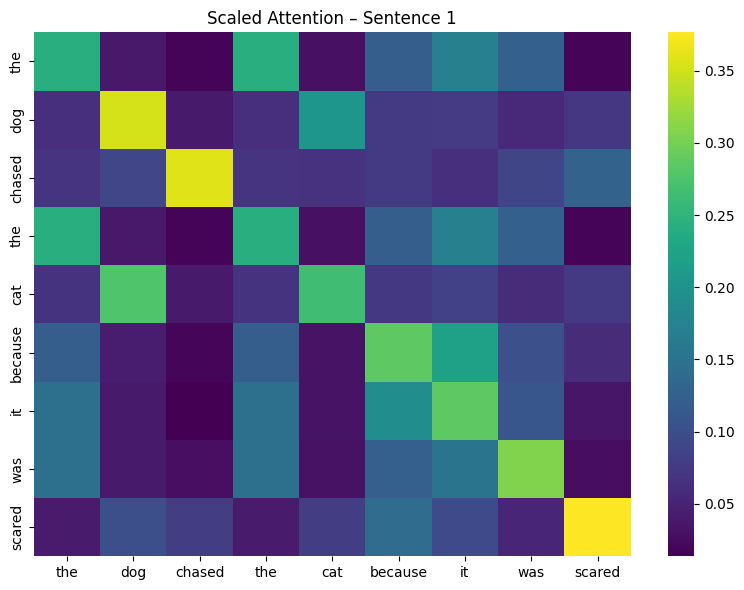

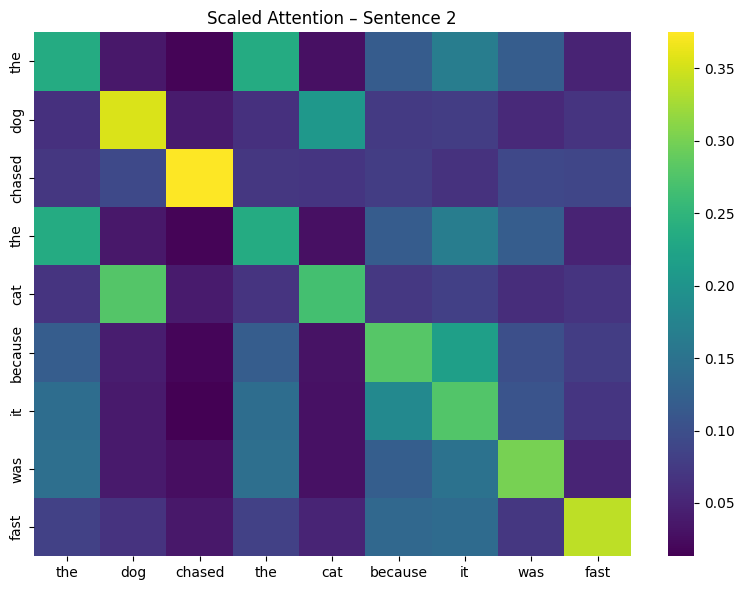

In [15]:
sentence1 = "The dog chased the cat because it was scared."
sentence2 = "The dog chased the cat because it was fast."

# Attention with scaling
sentences = [
    "The dog chased the cat because it was scared.",
    "The dog chased the cat because it was fast."
]

for i, sentence in enumerate(sentences, 1):
    tokens, X = sentence_to_matrix(sentence, glove)
    _, weights_scaled = scaled_dot_product_attention(X, X, X)
    
    plot_attention(tokens, weights_scaled,
                   title=f"Scaled Attention – Sentence {i}",
                   save_path=f"../outputs/sentence{i}_scaled.png")

## Results: Scaled Self-Attention

In the scaled attention heatmaps, the diagonal remains dominant but not overwhelming. Each token assigns the highest weight to itself, with diagonal values around 0.30–0.38. However, unlike the no-scaling case, off-diagonal interactions remain visible.

The nouns “dog” and “cat” show moderate mutual attention, reflecting semantic similarity in embedding space. The conjunction “because” exhibits mild attention toward nearby structural tokens such as “it” and “was,” but this interaction is secondary to its self-focus. The pronoun “it” distributes attention across adjacent words rather than concentrating strongly on either “dog” or “cat.”

Importantly, the change from “scared” to “fast” does not meaningfully alter the earlier attention structure. The difference primarily appears in the final token’s row and column, while the broader distribution remains stable. This suggests that scaled self-attention applied directly to static embeddings captures similarity relationships but does not dynamically encode sentence-level semantic shifts.

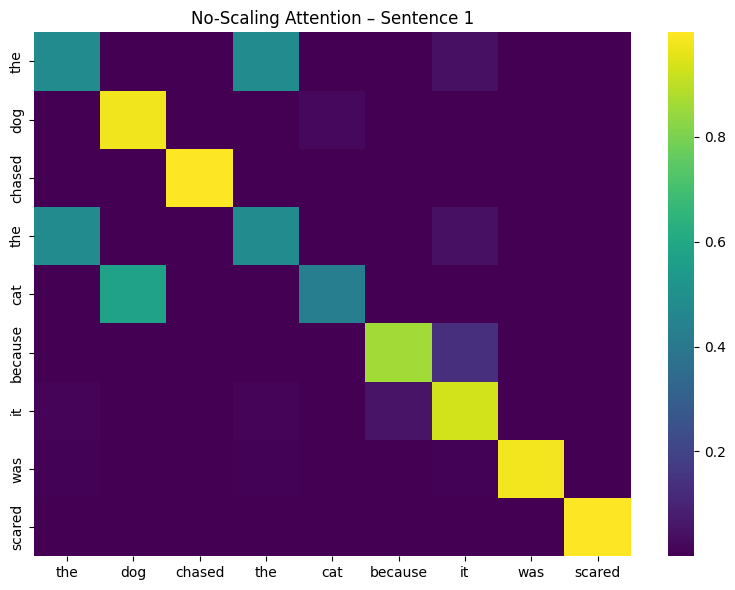

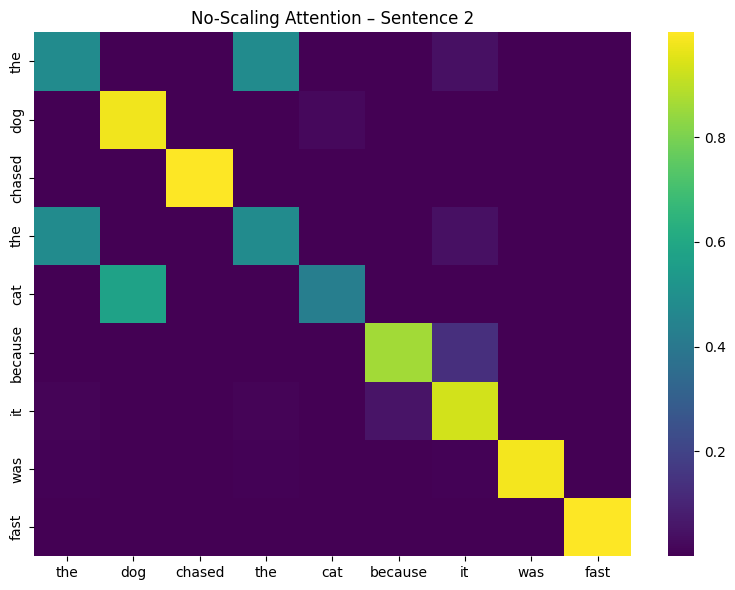

In [16]:
# Attention without scaling

for i, sentence in enumerate(sentences, 1):
    tokens, X = sentence_to_matrix(sentence, glove)
    _, weights_noscale = dot_product_attention_no_scaling(X, X, X)
    
    plot_attention(tokens, weights_noscale,
                   title=f"No-Scaling Attention – Sentence {i}",
                   save_path=f"../outputs/sentence{i}_noscaled.png")

## Results: Attention Without Scaling

When the scaling factor is removed, the attention matrices become almost entirely diagonal. The diagonal values approach 1.0, while nearly all off-diagonal entries shrink toward zero. This produces a matrix that closely resembles an identity matrix, meaning each token overwhelmingly attends to itself.

Compared to the scaled case, contextual interaction is almost completely suppressed. Words such as “dog” and “cat” no longer influence each other, and the pronoun “it” becomes nearly self-focused. The two sentences also appear nearly identical under no-scaling attention, indicating that without normalization, the mechanism becomes overly confident and insensitive to broader semantic structure.

## Comparative Analysis

The contrast between scaled and unscaled attention highlights the functional importance of normalization in the attention mechanism. When the scaling factor is applied, attention remains distributed, allowing tokens to influence one another beyond simple self-similarity. Without scaling, however, the softmax becomes overly sharp, causing attention to collapse toward self-focus and suppress cross-token interaction.

This comparison demonstrates that dividing by $$\sqrt(d_k)$$ is not merely a technical adjustment but a crucial step for maintaining meaningful contextual mixing. Scaling controls the confidence of the softmax distribution and preserves the capacity for relational structure to emerge within the sentence.

## Limitations & Future Work

This experiment applies self-attention directly to static GloVe embeddings without learned projection matrices, positional encodings, or training. As a result, attention primarily reflects embedding similarity rather than syntactic structure or true contextual reasoning. The inability of the pronoun “it” to meaningfully shift attention between “dog” and “cat” highlights this limitation.

Future work could incorporate learned projection matrices (W_Q, W_K, W_V), positional encodings, or fine-tuning on a supervised task to observe how contextual representations evolve during training. Extending the experiment to multi-head attention would also allow examination of how different heads capture distinct relational patterns.

## Conclusion

This project demonstrates that self-attention operates fundamentally as a similarity-based weighting mechanism. When applied directly to static GloVe embeddings, attention reflects geometric relationships in embedding space but does not dynamically encode deeper contextual reasoning. Changes in sentence meaning, such as shifting from “scared” to “fast,” do not meaningfully alter earlier token interactions, revealing the limitations of static representations.

The experiment also clarifies the mathematical role of scaling in attention. By preventing softmax saturation, the $$\sqrt(d_k)$$ term preserves contextual interaction and enables richer token relationships. While attention alone does not guarantee semantic understanding, this investigation provides insight into the foundational mechanics that allow transformer architectures to scale into powerful contextual language models when combined with learned projections and training.